In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sqlalchemy import create_engine
from sqlalchemy import inspect

In [ ]:
host = "creditreport.cvvccrp8oiue.us-east-2.rds.amazonaws.com"
database = "postgres"
user = 'postgres' #os.getenv('PROJECT_USER')
password = 'credit1234'#os.getenv('PROJECT_PASSWORD')

In [ ]:
#  Import and read the train.csv.
credit_df = pd.read_csv("Resources/Project_filtered_train.csv")

# sql alchemy to pull from project_test

credit_df.head(10)

In [20]:
# Drop the non-beneficial ID columns and nulls
credit_df = credit_df.drop(["ID","Customer_ID", "Name", "SSN"],1)
credit_df = credit_df.dropna()
credit_df.head()

/Users/neeshma_sweetie/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,1,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,2,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,31.944960,266.0,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
3,4,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,31.377862,268.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
4,5,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good
5,6,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,27.262259,270.0,No,49.574949,62.430172,Low_spent_Small_value_payments,340.479212,Good


In [21]:
# check correlations
credit_df[['Age','Annual_Income']].corr()

,Age,Annual_Income
Age,1.000000,0.092008
Annual_Income,0.092008,1.000000


In [22]:
# Create a new feature by dividing the Outstanding_Debt column by the Annual_Income column
credit_df['OutstandingDebt_AnnualIncome'] = credit_df['Outstanding_Debt']/credit_df['Annual_Income']

In [23]:
# check the train df dtypes
credit_df.dtypes

Month                             int64
Age                             float64
Occupation                       object
Annual_Income                   float64
Monthly_Inhand_Salary           float64
Num_Bank_Accounts               float64
Num_Credit_Card                 float64
Interest_Rate                   float64
Num_of_Loan                     float64
Type_of_Loan                     object
Delay_from_due_date             float64
Num_of_Delayed_Payment          float64
Changed_Credit_Limit            float64
Num_Credit_Inquiries            float64
Credit_Mix                       object
Outstanding_Debt                float64
Credit_Utilization_Ratio        float64
Credit_History_Age              float64
Payment_of_Min_Amount            object
Total_EMI_per_month             float64
Amount_invested_monthly         float64
Payment_Behaviour                object
Monthly_Balance                 float64
Credit_Score                     object
OutstandingDebt_AnnualIncome    float64


In [24]:
# train_df number of unique entries per variable
credit_df.nunique()

Month                               8
Age                                43
Occupation                         15
Annual_Income                   12488
Monthly_Inhand_Salary           13231
Num_Bank_Accounts                  12
Num_Credit_Card                    12
Interest_Rate                      34
Num_of_Loan                        10
Type_of_Loan                     6261
Delay_from_due_date                68
Num_of_Delayed_Payment             31
Changed_Credit_Limit             4375
Num_Credit_Inquiries               18
Credit_Mix                          3
Outstanding_Debt                12203
Credit_Utilization_Ratio        97909
Credit_History_Age                404
Payment_of_Min_Amount               3
Total_EMI_per_month             11886
Amount_invested_monthly         82608
Payment_Behaviour                   6
Monthly_Balance                 96037
Credit_Score                        3
OutstandingDebt_AnnualIncome    12500
dtype: int64

In [25]:
# Look at ocupation value counts
credit_df.Occupation.value_counts()

Lawyer           6938
Engineer         6708
Architect        6699
Mechanic         6637
Scientist        6608
Accountant       6600
Developer        6591
Media_Manager    6580
Teacher          6532
Entrepreneur     6501
Doctor           6431
Journalist       6394
Manager          6289
Musician         6226
Writer           6175
Name: Occupation, dtype: int64

<AxesSubplot:ylabel='Density'>

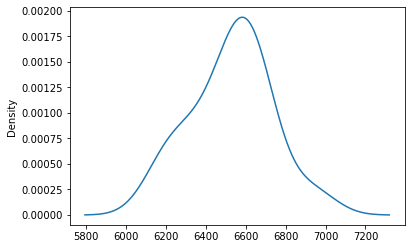

In [26]:
# Visualize the value counts of Occupation
occupation_counts = credit_df.Occupation.value_counts()
occupation_counts.plot.density()

In [27]:
# Look at type of loan value counts
credit_df.Type_of_Loan.value_counts().to_frame().head(12)

,Type_of_Loan
No Data,11149
Not Specified,1369
Credit-Builder Loan,1258
Personal Loan,1244
Debt Consolidation Loan,1244
Student Loan,1202
Payday Loan,1175
Mortgage Loan,1149
Auto Loan,1123
Home Equity Loan,1114


<AxesSubplot:ylabel='Density'>

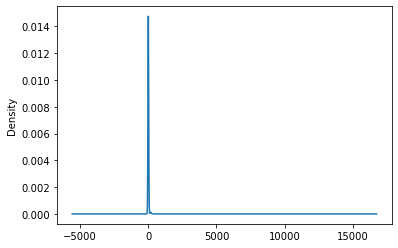

In [28]:
# Visualize the value counts of type of loan
loan_type_counts = credit_df.Type_of_Loan.value_counts()
loan_type_counts.plot.density()

In [29]:
# Bin lower density variables
replace_loan_type = list(loan_type_counts[loan_type_counts < 350].index)

# Replace in DF
for loan in replace_loan_type:
    credit_df.Type_of_Loan = credit_df.Type_of_Loan.replace(loan, 'Other')

# Check binning
credit_df.Type_of_Loan.value_counts()

Other                      75882
No Data                    11149
Not Specified               1369
Credit-Builder Loan         1258
Debt Consolidation Loan     1244
Personal Loan               1244
Student Loan                1202
Payday Loan                 1175
Mortgage Loan               1149
Auto Loan                   1123
Home Equity Loan            1114
Name: Type_of_Loan, dtype: int64

<AxesSubplot:ylabel='Density'>

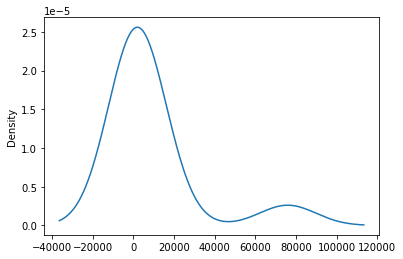

In [30]:
credit_df.Type_of_Loan.value_counts().plot.density()

In [31]:
# Drop Type_of_Loans column 
credit_df = credit_df.drop(['Type_of_Loan'],1)

/Users/neeshma_sweetie/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [32]:
# Create a copy of the df before encoding (to use later for the binary classidication)
credit_df_copy = credit_df.copy()
credit_df_copy.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,OutstandingDebt_AnnualIncome
0,1,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,...,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good,0.042376
1,2,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,-1.0,...,809.98,31.944960,266.0,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good,0.042376
3,4,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,5.0,...,809.98,31.377862,268.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good,0.042376
4,5,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,6.0,...,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good,0.042376
5,6,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,8.0,...,809.98,27.262259,270.0,No,49.574949,62.430172,Low_spent_Small_value_payments,340.479212,Good,0.042376


In [33]:
# create a copy for lgbm with credit score encoded in one column
credit_df_lgbm = credit_df.copy()
credit_df_lgbm.Credit_Score = credit_df_lgbm.Credit_Score.replace('Poor', '0')
credit_df_lgbm.Credit_Score = credit_df_lgbm.Credit_Score.replace('Standard', '1')
credit_df_lgbm.Credit_Score = credit_df_lgbm.Credit_Score.replace('Good', '2')
credit_df_lgbm.Credit_Score 

0        2
1        2
3        2
4        2
5        2
        ..
99995    0
99996    0
99997    0
99998    1
99999    0
Name: Credit_Score, Length: 97909, dtype: object

In [19]:
# Generate our categorical variable lists
credit_cat = credit_df.dtypes[credit_df.dtypes == "object"].index.tolist()
credit_cat

['Occupation',
 'Credit_Mix',
 'Payment_of_Min_Amount',
 'Payment_Behaviour',
 'Credit_Score']

In [20]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(credit_df[credit_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(credit_cat)
encode_df.head()

,Occupation_Accountant,Occupation_Architect,Occupation_Developer,Occupation_Doctor,Occupation_Engineer,Occupation_Entrepreneur,Occupation_Journalist,Occupation_Lawyer,Occupation_Manager,Occupation_Mechanic,...,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Large_value_payments,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments,Credit_Score_Good,Credit_Score_Poor,Credit_Score_Standard
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [21]:
# merge encoded features and drop originals
credit_df = credit_df.merge(encode_df, left_index=True, right_index=True)
credit_df = credit_df.drop(credit_cat, 1)
credit_df.head()

/Users/neeshma_sweetie/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Large_value_payments,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments,Credit_Score_Good,Credit_Score_Poor,Credit_Score_Standard
0,1,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,7.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,-1.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,4,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,5.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,6.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5,6,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,8.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [19]:
# split preprocessed data into features and target
y = credit_df[['Credit_Score_Good', 'Credit_Score_Poor','Credit_Score_Standard']]
X = credit_df.drop(columns=['Credit_Score_Good', 'Credit_Score_Poor','Credit_Score_Standard'])

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [20]:
# create a StandardScaler instances
scaler = StandardScaler()

# fit the StandardScaler
X_scaler = scaler.fit(X_train)

# scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [37]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.695


In [38]:
len(X_train_scaled[0])

57

In [63]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 100
hidden_nodes_layer2 = 50
hidden_nodes_layer3 = 15


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check the structure of the model
nn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 100)               5800      
                                                                 
 dense_24 (Dense)            (None, 50)                5050      
                                                                 
 dense_25 (Dense)            (None, 15)                765       
                                                                 
 dense_26 (Dense)            (None, 3)                 48        
                                                                 
Total params: 11,663
Trainable params: 11,663
Non-trainable params: 0
_________________________________________________________________


In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints_categorical/",exist_ok=True)
checkpoint_path = "checkpoints_categorical/weights.{epoch:02d}.hdf5"

# Compile the model
nn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')

In [66]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=75)

Epoch 1/75
2247/2247 [==============================] - 13s 5ms/step - loss: 0.8063 - accuracy: 0.6169
Epoch 2/75
2247/2247 [==============================] - 11s 5ms/step - loss: 0.7887 - accuracy: 0.6244
Epoch 3/75
2247/2247 [==============================] - 10s 5ms/step - loss: 0.7812 - accuracy: 0.6269
Epoch 4/75
2247/2247 [==============================] - 10s 5ms/step - loss: 0.7734 - accuracy: 0.6299
Epoch 5/75
2247/2247 [==============================] - 12s 6ms/step - loss: 0.7654 - accuracy: 0.6297
Epoch 6/75
2247/2247 [==============================] - 13s 6ms/step - loss: 0.7570 - accuracy: 0.6367
Epoch 7/75
2247/2247 [==============================] - 13s 6ms/step - loss: 0.7490 - accuracy: 0.6388
Epoch 8/75
2247/2247 [==============================] - 28s 12ms/step - loss: 0.7405 - accuracy: 0.6447
Epoch 9/75
2247/2247 [==============================] - 18s 8ms/step - loss: 0.7315 - accuracy: 0.6514
Epoch 10/75
2247/2247 [==============================] - 13s 6ms/step - 

In [67]:
# Evaluate the model using the test data (ReLU)
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

749/749 - 2s - loss: 0.8283 - accuracy: 0.6450 - 2s/epoch - 3ms/step
Loss: 0.8282716274261475, Accuracy: 0.6449674367904663


In [68]:
# Export our model to HDF5 file
nn.save("trained_categorical_credit_score.h5")

Trying the Same Model with 2 Outputs Instead of 3
- will create more trainable data compared to # of outputs
- will possibly lose information (users may want the differentiation of good vs standard)

In [31]:
#combine the Good and Standard output
credit_df_copy.Credit_Score = credit_df_copy.Credit_Score.replace('Standard', 'Good')

In [32]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df2 = pd.DataFrame(enc.fit_transform(credit_df_copy[credit_cat]))

# Add the encoded variable names to the dataframe
encode_df2.columns = enc.get_feature_names_out(credit_cat)

# Drop the credit_score_poor column
encode_df2 = encode_df2.drop(columns=['Credit_Score_Poor'])
encode_df2.head()

,Occupation_Accountant,Occupation_Architect,Occupation_Developer,Occupation_Doctor,Occupation_Engineer,Occupation_Entrepreneur,Occupation_Journalist,Occupation_Lawyer,Occupation_Manager,Occupation_Mechanic,...,Payment_of_Min_Amount_NM,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Large_value_payments,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments,Credit_Score_Good
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [33]:
# merge encoded features and drop originals
credit_df_copy = credit_df_copy.merge(encode_df2, left_index=True, right_index=True)
credit_df_copy = credit_df_copy.drop(credit_cat, 1)
credit_df_copy.head()

/Users/neeshma_sweetie/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Payment_of_Min_Amount_NM,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Large_value_payments,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments,Credit_Score_Good
0,1,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,7.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,-1.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,5.0,4.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,5,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,6.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5,6,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,8.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [34]:
# split preprocessed data into features and target
y2 = credit_df_copy[['Credit_Score_Good']]
X2 = credit_df_copy.drop(columns=['Credit_Score_Good'])

# split into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify=y2)

In [35]:
# create a StandardScaler instances
scaler = StandardScaler()

# fit the StandardScaler
X_scaler = scaler.fit(X_train2)

# scale the data
X_train_scaled2 = X_scaler.transform(X_train2)
X_test_scaled2 = X_scaler.transform(X_test2)

In [20]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled2, y_train2)

# Evaluate the model
y_pred2 = rf_model.predict(X_test_scaled2)
print(f" Random forest predictive accuracy: {accuracy_score(y_test2,y_pred2):.3f}")

/Users/neeshma_sweetie/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


 Random forest predictive accuracy: 0.825


In [39]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled2[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 50
hidden_nodes_layer3 = 15


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 80)                4640      
                                                                 
 dense_4 (Dense)             (None, 50)                4050      
                                                                 
 dense_5 (Dense)             (None, 15)                765       
                                                                 
 dense_6 (Dense)             (None, 1)                 16        
                                                                 
Total params: 9,471
Trainable params: 9,471
Non-trainable params: 0
_________________________________________________________________


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints_binary/",exist_ok=True)
checkpoint_path = "checkpoints_binary/weights.{epoch:02d}.hdf5"

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')

In [41]:
# Train the model
fit_model = nn.fit(X_train_scaled2, y_train2, epochs=100)

Epoch 1/100
2247/2247 [==============================] - 11s 5ms/step - loss: 0.5174 - accuracy: 0.7541
Epoch 2/100
2247/2247 [==============================] - 12s 5ms/step - loss: 0.5044 - accuracy: 0.7578
Epoch 3/100
2247/2247 [==============================] - 14s 6ms/step - loss: 0.4986 - accuracy: 0.7599
Epoch 4/100
2247/2247 [==============================] - 13s 6ms/step - loss: 0.4926 - accuracy: 0.7609
Epoch 5/100
2247/2247 [==============================] - 12s 5ms/step - loss: 0.4859 - accuracy: 0.7634
Epoch 6/100
2247/2247 [==============================] - 18s 8ms/step - loss: 0.4789 - accuracy: 0.7660
Epoch 7/100
2247/2247 [==============================] - 12s 5ms/step - loss: 0.4719 - accuracy: 0.7692
Epoch 8/100
2247/2247 [==============================] - 15s 7ms/step - loss: 0.4644 - accuracy: 0.7731
Epoch 9/100
2247/2247 [==============================] - 11s 5ms/step - loss: 0.4585 - accuracy: 0.7761
Epoch 10/100
2247/2247 [==============================] - 13s 6m

In [42]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled2,y_test2,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

749/749 - 3s - loss: 0.5610 - accuracy: 0.7698 - 3s/epoch - 4ms/step
Loss: 0.5609500408172607, Accuracy: 0.7698214054107666


In [43]:
# Export our model to HDF5 file
nn.save("trained_binary_credit_score.h5")

# Trying other tree based models

xgboost

In [38]:
from xgboost import XGBClassifier
# fit model to training data (3 outputs)
model = XGBClassifier()
model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [39]:
# make predictions
y_pred = model.predict(X_test_scaled)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 58.31%


In [40]:
# fit model to the binary classification dataset
model.fit(X_train_scaled2, y_train2)
# make predictions
y_pred = model.predict(X_test_scaled2)
# evaluate predictions
accuracy = accuracy_score(y_test2, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.89%


lightgbm

In [34]:
# convert credit score column to int
credit_df_lgbm['Credit_Score'] = credit_df_lgbm['Credit_Score'].astype('int')
# Generate our categorical variable lists
credit_cat = credit_df_lgbm.dtypes[credit_df_lgbm.dtypes == "object"].index.tolist()

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(credit_df_lgbm[credit_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(credit_cat)
encode_df.head()

,Occupation_Accountant,Occupation_Architect,Occupation_Developer,Occupation_Doctor,Occupation_Engineer,Occupation_Entrepreneur,Occupation_Journalist,Occupation_Lawyer,Occupation_Manager,Occupation_Mechanic,...,Credit_Mix_Standard,Payment_of_Min_Amount_NM,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Large_value_payments,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [35]:
# merge encoded features and drop originals
credit_df_lgbm = credit_df_lgbm.merge(encode_df, left_index=True, right_index=True)
credit_df_lgbm = credit_df_lgbm.drop(credit_cat, 1)
credit_df_lgbm.head()

/Users/neeshma_sweetie/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix_Standard,Payment_of_Min_Amount_NM,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Large_value_payments,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments
0,1,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,7.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,-1.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,5.0,4.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,6.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,6,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,8.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:
#split features and target
X = credit_df_lgbm.drop(columns=['Credit_Score'])
y = credit_df_lgbm['Credit_Score']

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [37]:
# create a StandardScaler instances
scaler = StandardScaler()

# fit the StandardScaler
X_scaler = scaler.fit(X_train)

# scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [38]:
from lightgbm import LGBMClassifier
model = LGBMClassifier()

In [ ]:
# build the model
model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],eval_metric='logloss')